In [1]:
# import matplotlib.pyplot as plt
# import matplotlib.style
# from Histo import SdHisto
# from Monit import Monit
# import numpy as np
# import signal
# import matplotlib

from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import *
from datetime import datetime

# from matplotlib.colors import TABLEAU_COLORS
# from matplotlib import dates
# from datetime import datetime

# matplotlib.use('TkAgg')
# import scienceplots

# matplotlib.style.use(['science', 'ieee', 'no-latex'])


14:39:55 (   +1.7s) [INFO   ] -- import logging
14:39:55 (  +230ms) [INFO   ] -- import numpy as np
14:39:55 (   +11ms) [INFO   ] -- import uncertainties
14:39:56 (  +762ms) [INFO   ] -- import pandas as pd
14:39:56 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
14:39:56 (    +3ms) [INFO   ] -- import binaries.tools as tools
14:39:56 (  +604ms) [INFO   ] -- import matplotlib.pyplot as plt
14:39:57 (   +1.1s) [INFO   ] -- import seaborn as so
14:39:57 (    +4ms) [INFO   ] -- import plotting.tools as plot
14:39:58 (   +24ms) [DEBUG  ] -- font size set to 9.5
14:39:58 (    +0ms) [DEBUG  ] -- label size set to 13.0
14:39:58 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
14:39:58 (    +1ms) [DEBUG  ] -- markersize set to 2.0
14:39:58 (    +1ms) [DEBUG  ] -- usetex set to False
14:39:58 (   +55ms) [INFO   ] -- set MONI_PATH = '/cr/work/filip/monit_and_sd/'
14:39:58 (    +1ms) [INFO   ] -- set HIST_PATH = '/cr/work/filip/monit_and_sd/'
14:39:58 (    +1ms) [INFO   ]

In [2]:
# reject 

from datetime import datetime

PROBLEM_START = datetime.strptime("Tue Jan 14 13:34:52 2025", "%a %b %d %H:%M:%S %Y").timestamp()
PROBLEM_STOP = datetime.strptime("Fri Jan 17 09:22:46 2025", "%a %b %d %H:%M:%S %Y").timestamp()

# Tue Jan 14 13:34:52 2025        # start of problems
# Fri Jan 17 09:22:46 2025        # end of problems

14:45:18 (  +33.9s) [INFO   ] -- received 10 file(s) as input


14:45:19 (   +1.8s) [INFO   ] -- View monit keys with self.keys()


SSD SdHisto fit failed: large fit error for SSD: 33%
SSD SdHisto fit failed: large fit error for SSD: 23%
SSD SdHisto fit failed: large fit error for SSD: 24%
SSD SdHisto fit failed: large fit error for SSD: 50%
SSD SdHisto fit failed: large fit error for SSD: 24%
SSD SdHisto fit failed: large fit error for SSD: 38%
SSD SdHisto fit failed: large fit error for SSD: 74%


14:45:31 (  +11.4s) [INFO   ] -- found 401 entries for key fTime and station #609
14:45:31 (   +48ms) [INFO   ] -- found 401 entries for key fPeak[4] and station #609
14:45:31 (   +58ms) [INFO   ] -- found 1989 entries for key fTime and station #943
14:45:31 (   +52ms) [INFO   ] -- found 1989 entries for key fPeak[4] and station #943
14:45:31 (  +200ms) [INFO   ] -- found 1990 entries for key fTime and station #944
14:45:31 (   +65ms) [INFO   ] -- found 1990 entries for key fPeak[4] and station #944
14:45:31 (  +216ms) [INFO   ] -- found 1988 entries for key fTime and station #949
14:45:31 (   +59ms) [INFO   ] -- found 1988 entries for key fPeak[4] and station #949
14:45:32 (  +197ms) [INFO   ] -- found 1986 entries for key fTime and station #954
14:45:32 (   +69ms) [INFO   ] -- found 1986 entries for key fPeak[4] and station #954


(20095.439588541663, 20105.14457152778)

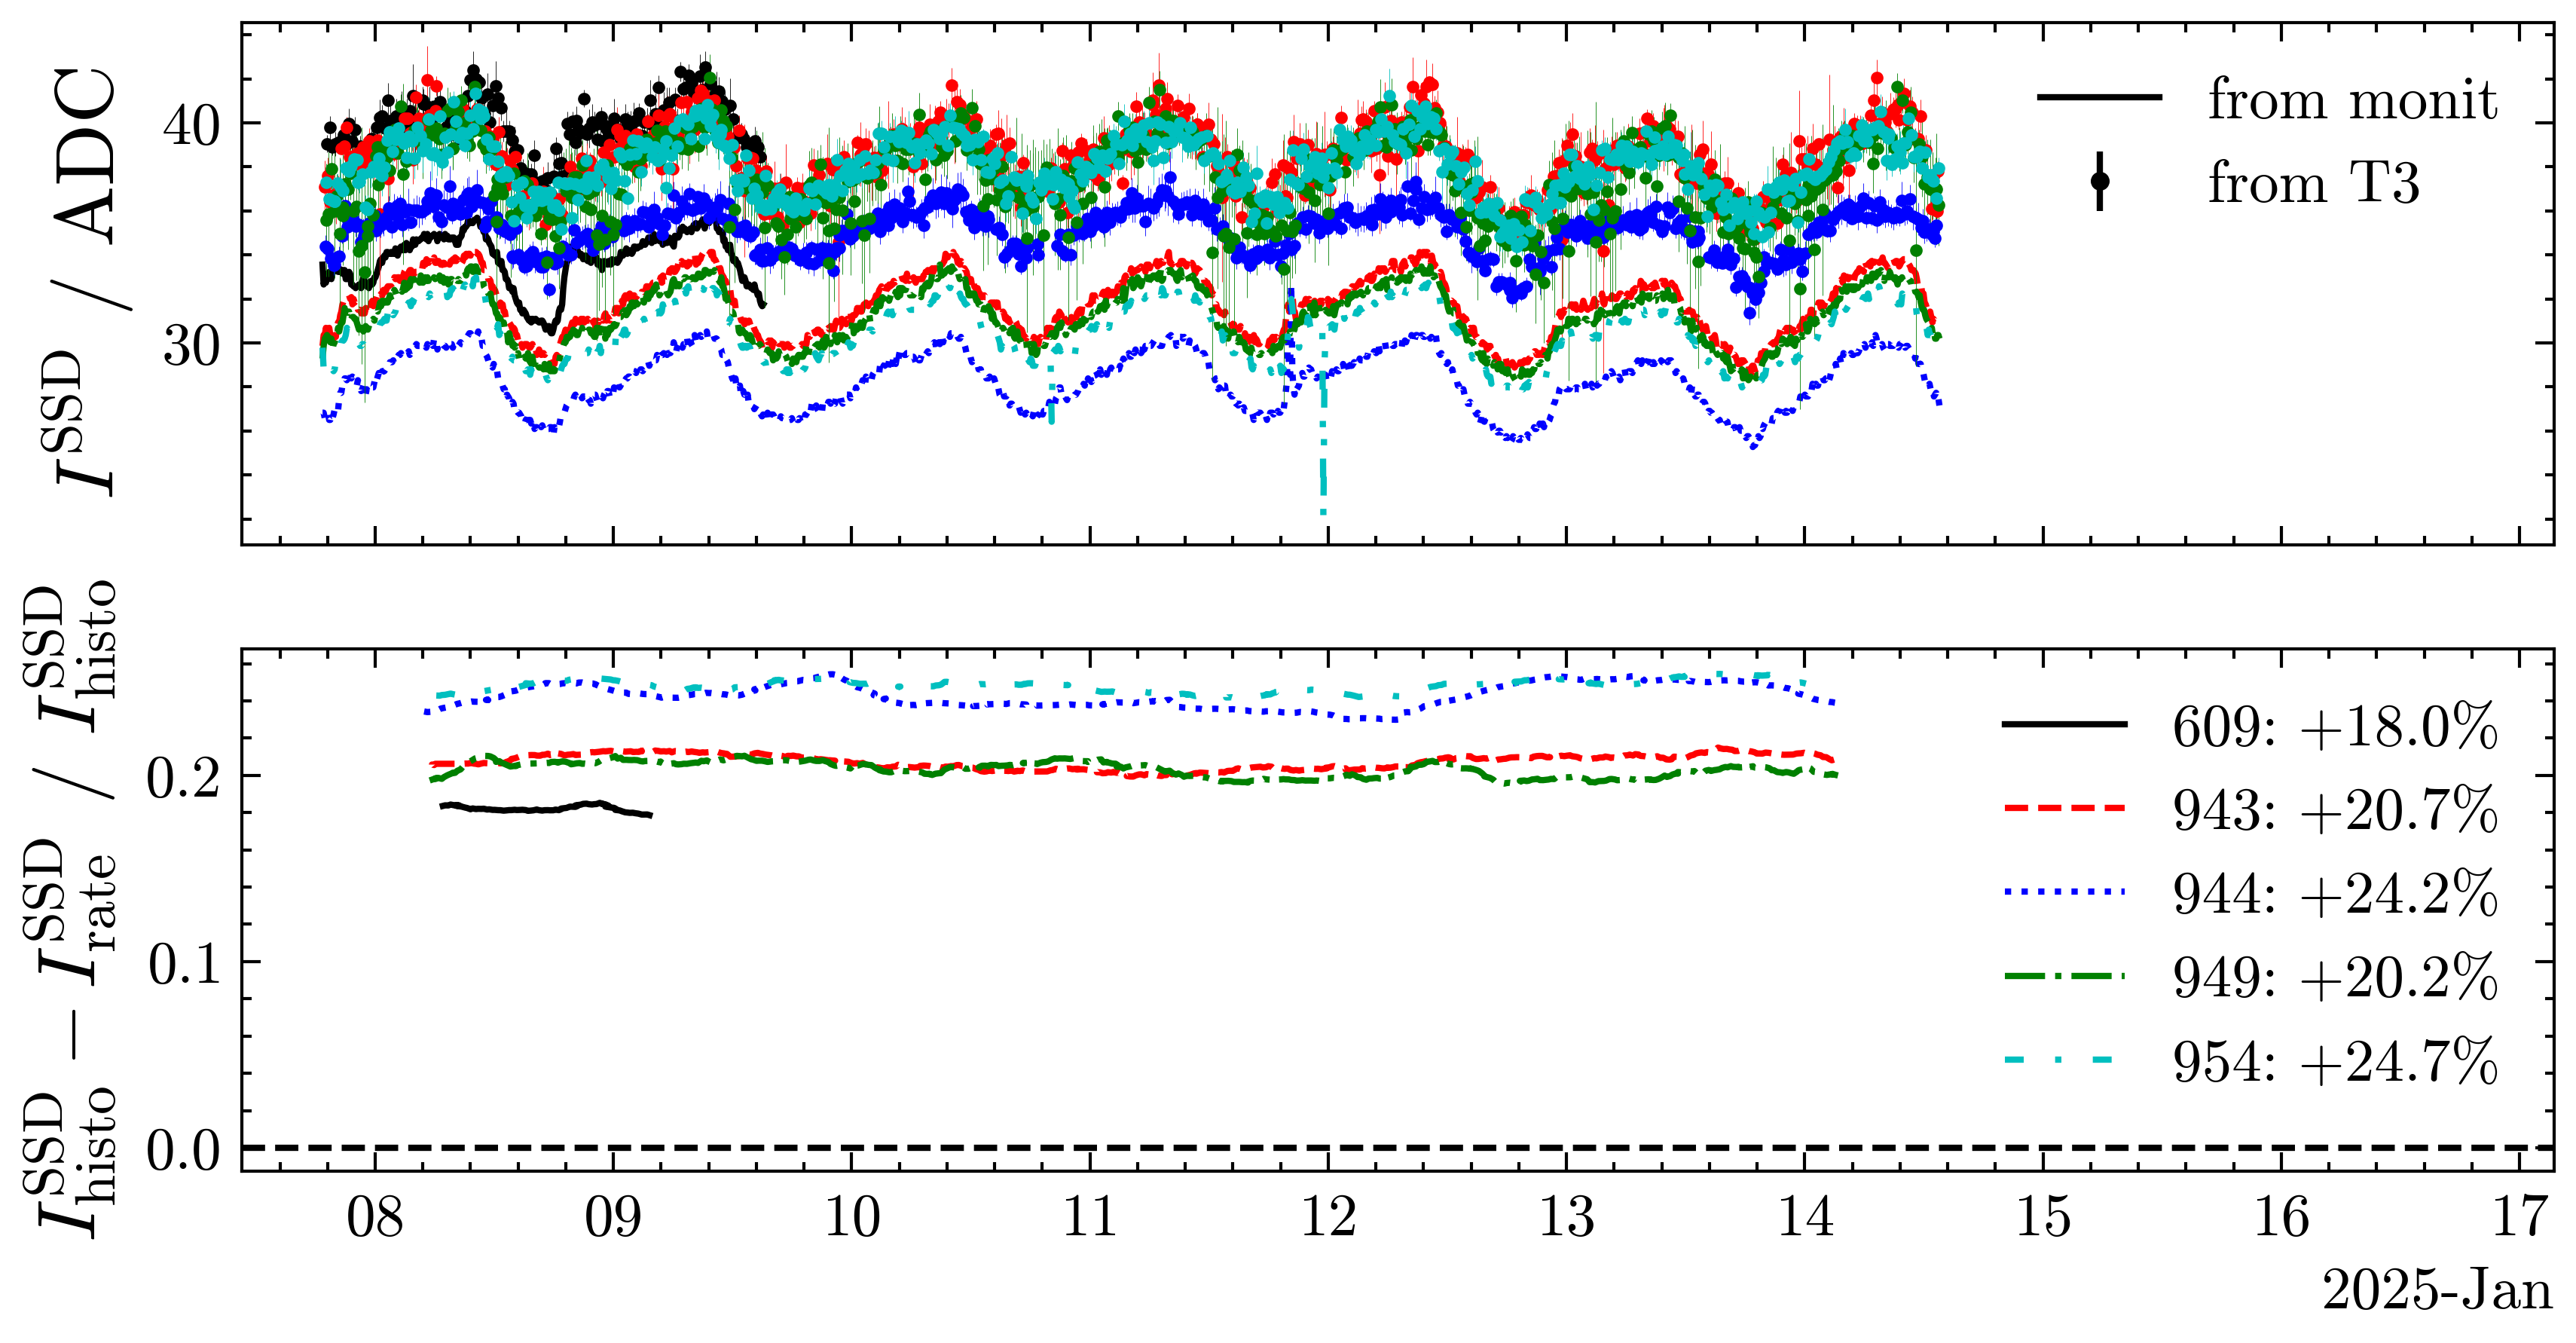

In [7]:

CORR_FACTOR = 1.21875

to_dt = lambda ts: [datetime.fromtimestamp(t) for t in ts]

monit = Monit(2025, 1, range(7, 17))

# offline calib
histos = np.loadtxt('peak.txt')
histos = np.split(histos, len(histos)//4)

peak_times = {
        609: [],
        943: [],
        944: [],
        949: [],
        954: [],
        }

peak_values = {
        609: [],
        943: [],
        944: [],
        949: [],
        954: [],
        }

for i, histo in enumerate(histos):
    station_id = int(histo[:, 0][0])
    daq_time   = histo[:, 1][0]
    timestamp  = int(histo[:, 2][0])
    tube_mask  = histo[:, 3][0]
    iPMT = histo[:, 4]

    if station_id in [945, 972, 948]: continue

    PeakHisto = SdHisto(peak=histo[:, 5:], pmt_mask=[0,0,0,1])
    try:
        # print(f'{i:03} ping...', end='', flush=True)
        peak_charge = PeakHisto()
        # print('pong!')

        peak_times[station_id].append(timestamp)
        peak_values[station_id].append(peak_charge['peak'][-1])
        
        #fig = PeakHisto.plot()
        #fig.savefig(f"success/{station_id}_{timestamp}.png")
        #plt.clf()

    except KeyboardInterrupt:
        print('Thanks')
        fig = PeakHisto.plot()
        fig.savefig(f"fail/{station_id}_{timestamp}.png")
        plt.clf()
        continue

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# colors = iter(TABLEAU_COLORS)
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])

diffs = {}
# online calib
for _id in [609, 943, 944, 949, 954]: 

    c = next(colors)
    
    time = monit('fTime', _id)
    peak = monit('fPeak[4]', _id)
    peak = peak[:, -1] / CORR_FACTOR

    monit_time_mask = np.array([PROBLEM_START <= t <= PROBLEM_STOP for t in time])
    time = time[~monit_time_mask]
    peak = peak[~monit_time_mask]
    
    histo_time_mask = np.array([PROBLEM_START <= t <= PROBLEM_STOP for t in peak_times[_id]])
    nan_mask = ~np.isnan([x.n for x in peak_values[_id]])
    histo_mask = nan_mask & ~histo_time_mask

    peak_values[_id] = np.array(peak_values[_id])[histo_mask]
    peak_times[_id] = np.array(peak_times[_id])[histo_mask]

    ax1.plot(to_dt(time[1:]), peak[1:], marker='none', c=c)
    ax1.errorbar(to_dt(peak_times[_id]), [x.n for x in peak_values[_id]], 
                 yerr=[x.std_dev for x in peak_values[_id]],
                 ls='none', fmt='o', markersize=1, c=c, lw=0.1)

    min_index = [np.argmin(np.abs(t - time)) for t in peak_times[_id]]
    diff = (np.array([x.n for x in peak_values[_id]]) - peak[min_index]) / peak[min_index]

    # 1000s between events w/ running mean over 86 events = 23.89 hours
    ax2.plot(to_dt(time[min_index])[43:-42], 
             np.convolve(diff, np.ones(86)/86, mode='valid'), 
             color=c, label=f"{_id}: {np.nanmean(diff)*100:+.1f}%", 
             marker='none')
    # ax2.plot(to_dt(time[min_index]), diff, label=f"{_id}: {np.nanmean(diff)*100:+.1f}%", marker='none', c=c)

    if _id == 609: continue

    diffs[_id] = diff

ax1.errorbar([], [], [], fmt='ko', label='from T3')
ax1.plot([], [], c='k', label='from monit', marker='none')
ax2.axhline(0, c='k', ls='--')
ax1.set_ylabel('$I^\mathrm{SSD}$ / ADC')
ax2.set_ylabel('$I^\mathrm{SSD}_\mathrm{histo} - I^\mathrm{SSD}_\mathrm{rate}$ / $I^\mathrm{SSD}_\mathrm{histo}$')
ax1.legend()
ax2.legend()

plot.apply_datetime_format(ax2)

xmin, xmax = ax2.get_xlim()
ax2.set_xlim(xmin, xmax + 0.3 * (xmax-xmin))

# fig.savefig('peaks_v3.png')


In [ ]:
df = pd.DataFrame({'t': time})

for _id, vals in diffs.items():
    df_i = pd.DataFrame({_id: vals})
    df = df.join(df_i)

df = df.drop('t', axis=1)

so.pairplot(df, dropna=True)

In [ ]:
mm = Monit(2025,1,15)

In [ ]:
peak = mm('fPeak[4]', 943)
time = mm('fTime', 943)

In [ ]:
plt.plot(time, peak)